<a href="https://colab.research.google.com/github/SaashaJoshi/DICOM-pancreas/blob/master/DICOMPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import numpy as np
# import dicom
import os
import pathlib
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
# init_notebook_mode(connected=True) 

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# data_path = "..."
# output_path = working_path = "/home/saasha/Documents/"
# g = glob(data_path + '/*.dcm')

data_path = 'drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/'
output_path = working_path = 'drive/My Drive/'
g = glob(data_path + '/*.png')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 240 images.
First 5 filenames:
drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/000139.png
drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/000064.png
drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/000131.png
drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/000042.png
drive/My Drive/Pancreas-CT-PNG/PANCREAS_0001/000185.png


In [0]:
import cv2
data = []
for files in g:
    img = cv2.imread(files)
    data.append(img)

In [0]:
# for i in data:
#   cv2.imshow(i)

In [0]:
# Loading Images into a list for manipulation
def load_images(path):
    image_files = sorted([os.path.join(path, '/', file)
                          for file in os.listdir(path)
                          if file.endswith('.png')])
    return image_files

In [0]:
# # Loading Images into a list for manipulation
# def load_scan(path):
#     slices = [pathlib.Path(path + '/' + s) for s in os.listdir(path)]
#     slices.sort(key = lambda x: int(x.InstanceNumber))
#     try:
#         slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
#     except:
#         slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
#     for s in slices:
#         s.SliceThickness = slice_thickness
        
#     return slices

In [0]:
# Convert raw Voxel values to Houndsfeld units
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [7]:
id = 0
patient = load_images(data_path)
imgs = get_pixels_hu(patient)

AttributeError: ignored

In [8]:
np.save(output_path + 'images_%d.npy' % (id), imgs)

NameError: ignored

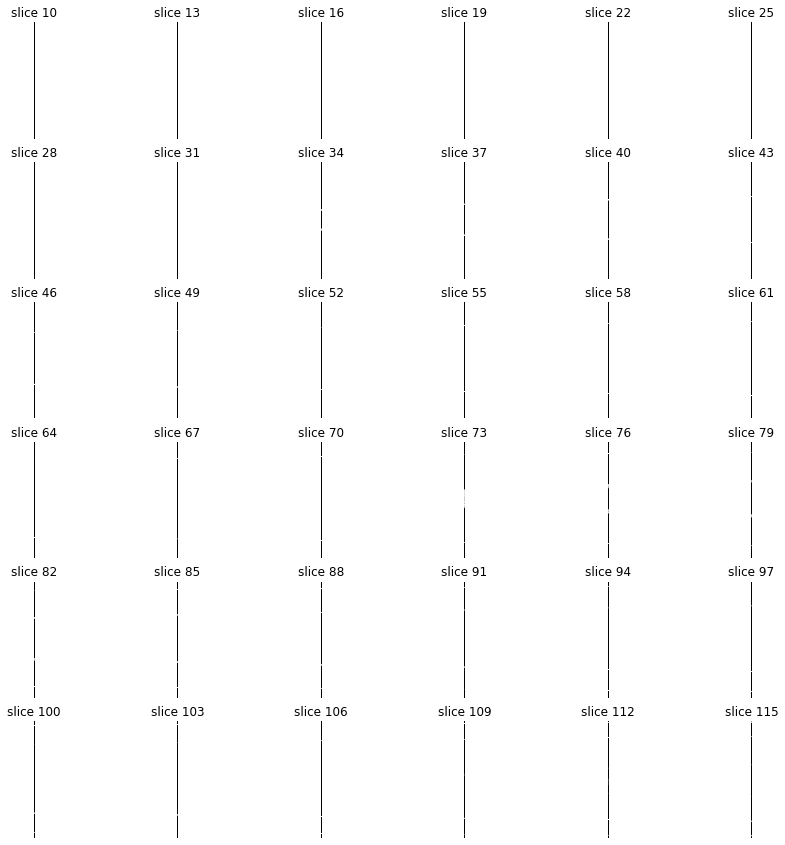

In [36]:
id = 0
imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[15, 15])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

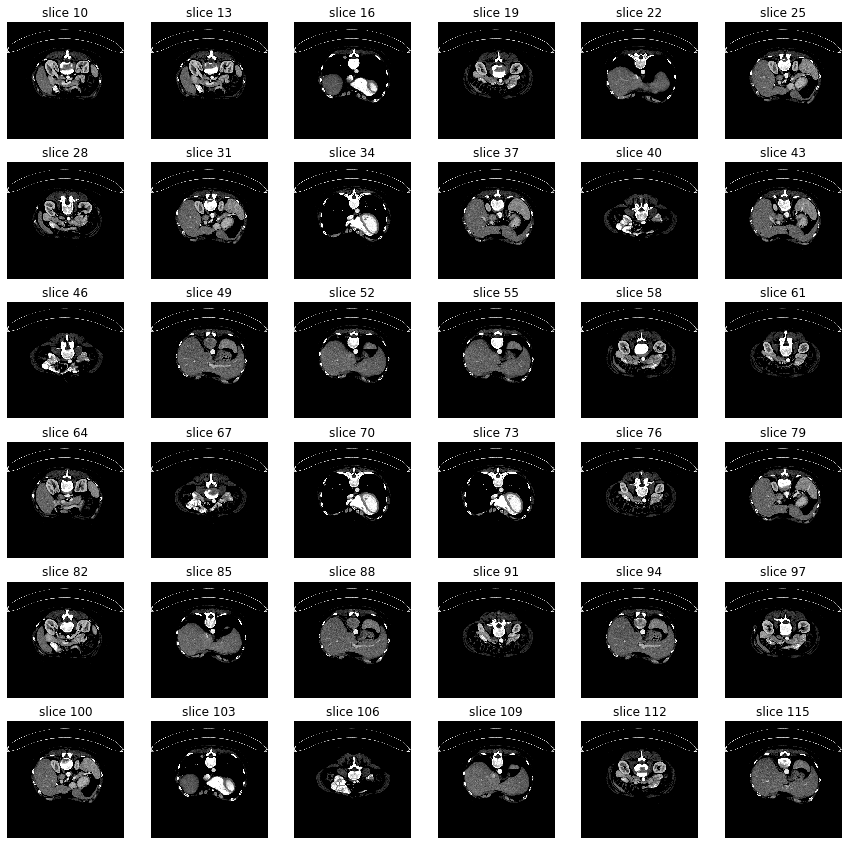

In [27]:
sample_stack(data)

In [29]:
# imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))
# sample_stack(imgs_to_process)

# imgs_to_process = np.load(output_path + data)
# sample_stack(imgs_to_process)

TypeError: ignored

In [42]:
id = 0
imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
# imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
imgs_after_resamp, spacing = resample(data, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (512, 512, 3)


AttributeError: ignored

In [0]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [43]:
# img = imgs_after_resamp[260]
img = data[10]
make_lungmask(img, display=True)

RuntimeError: ignored